In [8]:
!python -m atari_py.import_roms C:\Users\Mi\Desktop\gym\Roms\ROMS\ROMS

copying adventure.bin from C:\Users\Mi\Desktop\gym\Roms\ROMS\ROMS\Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to C:\Users\Mi\Anaconda3\lib\site-packages\atari_py\atari_roms\adventure.bin
copying air_raid.bin from C:\Users\Mi\Desktop\gym\Roms\ROMS\ROMS\Air Raid (Men-A-Vision) (PAL) ~.bin to C:\Users\Mi\Anaconda3\lib\site-packages\atari_py\atari_roms\air_raid.bin
copying alien.bin from C:\Users\Mi\Desktop\gym\Roms\ROMS\ROMS\Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to C:\Users\Mi\Anaconda3\lib\site-packages\atari_py\atari_roms\alien.bin
copying amidar.bin from C:\Users\Mi\Desktop\gym\Roms\ROMS\ROMS\Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to C:\Users\Mi\Anaconda3\lib\site-packages\atari_py\atari_roms\amidar.bin
copying assault.bin from C:\Users\Mi\Desktop\gym\Roms\ROMS\ROMS\Assault (AKA Sky Alien) (1983) (Bomb - Onbase) (CA281).bin to C:\Users\Mi\Anaconda3\lib\site-packages\atari_py\atari_roms\ass

In [ ]:
!pip uninstall gym[atari]

In [ ]:
!pip uninstall arari_py

In [ ]:
!pip install cmake

In [ ]:
!pip install atari_py

In [2]:
!pip install gym[atari]

  Using cached gym-0.18.3-py3-none-any.whl
  Using cached pyglet-1.5.15-py3-none-any.whl (1.1 MB)


In [ ]:
!pip install matplotlib

In [2]:
!pip install torch

  Using cached torch-1.8.1-cp38-cp38-win_amd64.whl (190.5 MB)


In [276]:
import gym
import atari_py

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from collections import namedtuple, deque
from itertools import count
from PIL import Image
import copy

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda', index=0)

In [237]:
class Cache:
    def __init__(self, capacity, state_shape):
        self.capacity = capacity
        self.states = torch.zeros((capacity, state_shape), device=device, dtype=torch.float)
        self.next_states = torch.zeros((capacity, state_shape), device=device)
        self.actions = torch.zeros(capacity, device=device, dtype=torch.long)
        self.rewards = torch.zeros(capacity, device=device, dtype=torch.float)
        self.dones = torch.zeros(capacity, device=device, dtype=torch.bool)
        
        self.index = 0
        self._full = False
        
    
    def push(self, state, next_state, action, reward, done):
        self.states[self.index] = state
        self.next_states[self.index] = next_state
        self.rewards[self.index] = reward
        self.dones[self.index] = done
        self.actions[self.index] = action
        
        self.index = self.index + 1
        if self.index == self.capacity:
            self.index %= self.capacity
            self._full = True
    
    def sample(self, batch_size):
        indexes = torch.randperm(self.capacity)[:batch_size]
        
        return self.states[indexes], self.next_states[indexes] \
                , self.actions[indexes], self.rewards[indexes], self.dones[indexes]
    
    
    def full(self):
        return self._full
    

Cache(5, 2).sample(2)

(tensor([[0., 0.],
         [0., 0.]], device='cuda:0'), tensor([[0., 0.],
         [0., 0.]], device='cuda:0'), tensor([0, 0], device='cuda:0'), tensor([0., 0.], device='cuda:0'), tensor([False, False], device='cuda:0'))

In [259]:
class Agent:
    def __init__(self, net, output_dim, lr, optimizer, loss_function
                 , gamma, eps, eps_min_bound, state_shape, cache_size, batch_size, iterations):
        
        self.policy_net = net
        self.target_net = copy.deepcopy(self.policy_net)
        
        self.policy_net.to(device)
        self.target_net.to(device)
        
        self.optimizer = optimizer(self.policy_net.parameters(), lr=lr)
        self.loss_function = loss_function
        
        self.output_dim = output_dim
        
        self.gamma = gamma
        self.eps = eps
        self.eps_decay = (eps - eps_min_bound) / iterations
        self.eps_min_bound = eps_min_bound
        
        self.cache = Cache(cache_size, state_shape)
        self.batch_size = batch_size
        
        self.iterations = iterations
    
    def select_action(self, state):
        self.eps -= self.eps_decay
        self.eps = max(self.eps, self.eps_min_bound)
        
        if np.random.random() < self.eps:
            return self.random_action()
        
        return self.policy_net(state).argmax().item()
    
    def random_action(self):
        return np.random.randint(0, self.output_dim)
    
    
    def fit(self):
        states, next_states, actions, rewards, dones = self.cache.sample(self.batch_size)
        
        target_q = torch.zeros(self.batch_size).to(device).float()
        with torch.no_grad():
            target_q = self.target_net(next_states).max(1)[0]
        target_q[done] = 0
        target_q = rewards + target_q * self.gamma
        
        actual_q = self.policy_net(states).gather(1, actions.unsqueeze(1))
        
        loss = self.loss_function(actual_q, target_q.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

### Mounatin Car

In [185]:
env = gym.make('MountainCar-v0')

In [260]:
net = nn.Sequential(
        nn.Linear(2, 16),
        nn.ReLU(),
        nn.Linear(16, 16),
        nn.ReLU(),
        nn.Linear(16, 3)
    )
agent = Agent(net, 3, 0.00003, optim.Adam, F.smooth_l1_loss, 0.99, 0.9, 0.1, 2, 5000, 100, 120_000)

In [188]:
%%time

done = True
total_reward = (0, 0)
reward_records = []

for i in range(agent.iterations):
    if done:
        reward_records.append(total_reward)
        total_reward = (0, 0)
        state = torch.tensor(env.reset()).to(device).float()
    if i % (agent.iterations // 5) == 0:
        print(f'{i} of {agent.iterations}')

    action = agent.select_action(state)
    next_state, reward, done, _ = env.step(action)
    
    reward = (reward, np.abs(next_state[1]))
    total_reward = (total_reward[0] + reward[0], total_reward[1] + reward[1])
    
    next_state = torch.tensor(next_state).float().to(device)

    agent.cache.push(state=state, next_state=next_state, action=action, reward=reward[1], done=done)
    state = next_state

    if agent.cache.full():
        agent.fit()

    if i % 2000 == 0:
        agent.target_net = copy.deepcopy(agent.policy_net)

0 of 120000
24000 of 120000
48000 of 120000
72000 of 120000
96000 of 120000
Wall time: 3min 46s


In [189]:
try:
    n_games = 1
    for i in range(n_games):
        done = False
        state = torch.tensor(env.reset()).to(device).float()
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)

            next_state = torch.tensor(next_state).float().to(device)

            state = next_state

            env.render()
finally:
    env.close()

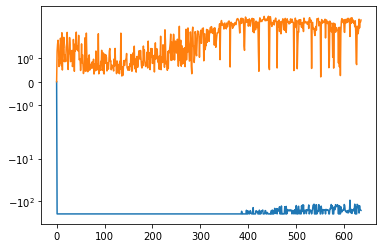

In [190]:
x = list(zip(*reward_records))
plt.yscale('symlog')
plt.plot(range(len(reward_records)), x[0])
plt.plot(range(len(reward_records)), x[1])
plt.show()

### Breakout

In [269]:
env = gym.make('BreakoutDeterministic-v4')
try:
    env.reset()
    state, reward, done, info = env.step(1)
finally:
    env.close()
    
info['ale.lives']

5

In [235]:
def image_to_tensor(image, size=[84,84], l=31, r=-17, t=6, b=-7):
    cropped = image[l:r, t:b]
    tensor = T.ToTensor()(cropped)
    mono = T.functional.rgb_to_grayscale(tensor)
    resized = T.functional.resize(mono, size)
    return resized

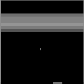

In [236]:
T.ToPILImage()(image_to_tensor(state))

In [296]:
class Cache:
    def __init__(self, capacity, *state_shape):
        self.capacity = capacity
        self.states = torch.zeros(capacity, *state_shape, device=device, dtype=torch.float)
        self.next_states = torch.zeros(capacity, *state_shape, device=device)
        self.actions = torch.zeros(capacity, device=device, dtype=torch.long)
        self.rewards = torch.zeros(capacity, device=device, dtype=torch.float)
        self.dones = torch.zeros(capacity, device=device, dtype=torch.bool)
        
        self.index = 0
        self._full = False
        
    
    def push(self, state, action, reward, done):
        self.states[self.index] = state
        self.rewards[self.index] = reward
        self.dones[self.index] = done
        self.actions[self.index] = action
        
        self.index = self.index + 1
        if self.index == self.capacity:
            self.index %= self.capacity
            self._full = True
    
    def sample(self, batch_size):
        indexes = []
        while len(indexes) < batch_size:
            r = np.random.randint(self.capacity - 1)
            if not self.dones[r]:
                indexes.append(r)
        
        return self.states[indexes], self.states[[i + 1 for i in indexes]], self.actions[indexes], self.rewards[indexes], self.dones[indexes]
    
    
    def full(self):
        return self._full
    

Cache(5, *(4, 84, 84)).sample(2);

In [ ]:
%%time

last_observations = deque(maxlen=4)
done = True
total_reward = 0
reward_records = []
lives = 5

for i in range(agent.iterations):
    if done:
        reward_records.append(total_reward)
        total_reward = 0
        observation = env.reset()
        
    if lives != info['ale.lives']:
        for _ in range(4):
            last_observations.append(observation)
        state = torch.tensor(list(last_observations), device=device, dtype=torch.float)
        lives = info['ale.lives']
        
    next_observation, reward, done, info = env.step(agent.select_action(state))

    last_observations.append(observation)
    
    agent.cache.push(state=state, action=action, reward=reward, done=done)
    state = next_state
    
    total_reward += reward
    
    if agent.cache.full() and np.random.random() < 0.25:
        agent.fit()

    if i % 2000 == 0:
        agent.target_net = copy.deepcopy(agent.policy_net)
        
    if i % (agent.iterations // 5) == 0:
        print(f'{i} of {agent.iterations}')

In [293]:
np.random.random()

0.7911015496710183